In [216]:
using TrajectoryOptimization
using RobotDynamics
import RobotZoo.Cartpole
using StaticArrays, LinearAlgebra

In [217]:
model = Cartpole()
n,m = size(model);

In [218]:
N = 101
Tf = 5.
h = Tf/(N-1)

0.05

In [219]:
x0 = @SVector zeros(n)
xf = @SVector [0, pi, 0, 0];  # i.e. swing up

In [254]:
# Set up
Q = 1.0*Diagonal(@SVector ones(n))
Qf = 100.0*Diagonal(@SVector ones(n))
R = 0.1*Diagonal(@SVector ones(m))
obj = LQRObjective(Q,R,Qf,xf,N);

In [288]:
# Create Empty ConstraintList
conSet = ConstraintList(n,m,N)

# Control Bounds
u_bnd = 3.0
bnd = BoundConstraint(n,m, u_min=-u_bnd, u_max=u_bnd)
add_constraint!(conSet, bnd, 1:N-1)

# Goal Constraint
goal = GoalConstraint(xf)
add_constraint!(conSet, goal, N)

In [289]:
prob = Problem(model, obj, xf, Tf, x0=x0, constraints=conSet);

In [290]:
u0 = @SVector fill(0.01,m)
U0 = [u0 for k = 1:N-1]
initial_controls!(prob, U0)
rollout!(prob);

In [291]:
using Altro
opts = SolverOptions(
    cost_tolerance_intermediate=1e-2,
    penalty_scaling=10.,
    penalty_initial=1.0
)

altro = ALTROSolver(prob, opts)
set_options!(altro, show_summary=true)
solve!(altro);


SOLVE COMPLETED
 solved using the ALTRO Solver,
 part of the Altro.jl package developed by the REx Lab at Stanford and Carnegie Mellon Universities

  Solve Statistics
    Total Iterations: 242
    Solve Time: 75.56025 (ms)

  Covergence
    Terminal Cost: 54.734968699655006
    Terminal dJ: -4.509325245139266
    Terminal gradient: 0.0004880337521692582
    Terminal constraint violation: 4.976240406406873e-7
    Solve Status: SOLVE_SUCCEEDED


In [292]:
println("max_violation: ", max_violation(altro))
println("cost:          ", cost(altro))
println("iterations:    ", iterations(altro));

max_violation: 4.976240406406873e-7
cost:          54.73498030858044
iterations:    242


In [293]:
# Extract the solution
X = states(altro);
U = controls(altro);

In [294]:
hcat(Vector.(X)...)

4×101 Array{Float64,2}:
  3.8646e-9     0.00127179   0.0047649  …  -0.00375649  -3.53295e-8
 -2.51939e-9   -0.00254358  -0.0093846      3.13402      3.14159
  2.14952e-9    0.0507882    0.0887925      0.150252     8.08715e-8
  6.46365e-10  -0.100744    -0.17118        0.303025    -1.07129e-7

In [295]:
using TrajOptPlots
using MeshCat
using Plots

vis = Visualizer()
render(vis)

┌ Info: MeshCat server started. You can open the visualizer by visiting the following URL in your browser:
│ http://127.0.0.1:8721
└ @ MeshCat /Users/zac/.julia/packages/MeshCat/GlCMx/src/visualizer.jl:73


MeshCat.DisplayedVisualizer(MeshCat.CoreVisualizer(MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String,Array{UInt8,1}}(), nothing, Dict{String,MeshCat.SceneTrees.SceneNode}()), Set{Any}(), ip"127.0.0.1", 8721))

In [296]:
TrajOptPlots.set_mesh!(vis, model)

MeshCat Visualizer with path /meshcat/robot/cart/pole at http://127.0.0.1:8721

In [297]:
visualize!(vis, altro);

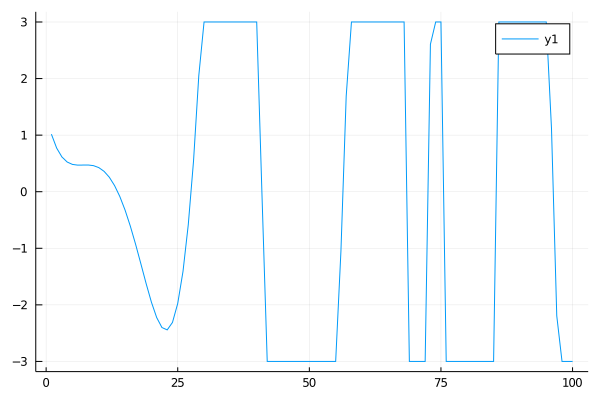

In [298]:
plot(U)